In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import torch
import os

In [2]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

In [11]:
dataframe = pd.read_csv("z_vs_q.csv")
dataframe.head()

,Step,resnt34 z,resnet50 z,rexnet150 z,resnet34 q,resnet50 q,rexnet150 q,Unnamed: 7,pleasant-firebrand-100 - test_acc_z
0,0,0.3749,0.3695,0.3450,0.3951,0.3933,0.3473,NaN,NaN
1,1,0.3992,0.3957,0.3462,0.4216,0.4280,0.3461,NaN,NaN
2,2,0.4080,0.4147,0.3494,0.4307,0.4412,0.3504,NaN,NaN
3,3,0.4053,0.4404,0.3759,0.4261,0.4717,0.3755,NaN,NaN
4,4,0.4287,0.4401,0.3860,0.4597,0.4777,0.3883,NaN,NaN


In [12]:
col2 = dataframe.columns[-1]

In [13]:
dataframe = dataframe.drop(columns=['Unnamed: 7', col2])

In [14]:
dataframe.head()

,Step,resnt34 z,resnet50 z,rexnet150 z,resnet34 q,resnet50 q,rexnet150 q
0,0,0.3749,0.3695,0.3450,0.3951,0.3933,0.3473
1,1,0.3992,0.3957,0.3462,0.4216,0.4280,0.3461
2,2,0.4080,0.4147,0.3494,0.4307,0.4412,0.3504
3,3,0.4053,0.4404,0.3759,0.4261,0.4717,0.3755
4,4,0.4287,0.4401,0.3860,0.4597,0.4777,0.3883


In [15]:
def get_sum(data, stepsize=10):
    cumsum = []
    
    for i in range(0, len(data), stepsize):
        cumsum.append(sum(data[i:i+stepsize]))

    cumsum=np.array(cumsum)/stepsize
    return cumsum

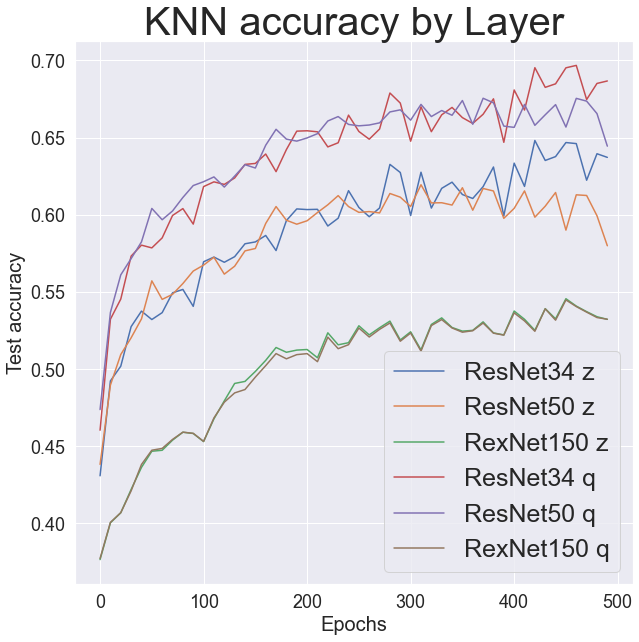

In [16]:
sns.set()
data = dataframe.to_numpy()[:, 1:]

summed = get_sum(data, 10)

jump_size = 10


plt.rcParams['figure.figsize']=(10,10)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.array([jump_size*np.arange(50)]).T, summed[:50])

ax.set_ylabel('Test accuracy', fontsize=20)
ax.set_xlabel("Epochs", fontsize=20)
ax.legend(["ResNet34 z", "ResNet50 z", "RexNet150 z", "ResNet34 q", "ResNet50 q", "RexNet150 q"], fontsize=25)
ax.set_title("KNN accuracy by Layer",fontsize=40)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.savefig("z_vs_q.png")

plt.show()

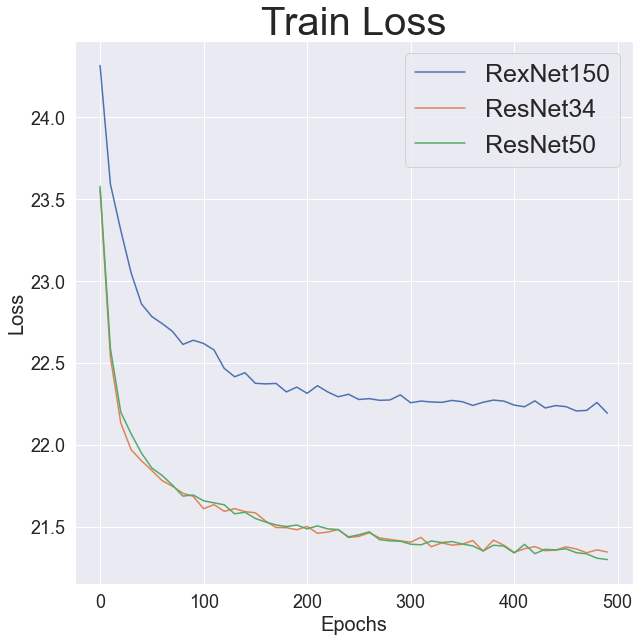

In [8]:
dataframe = pd.read_csv("train_loss.csv")

data = dataframe.to_numpy()[:, 1:]

jump_size = 10

summed = get_sum(data, jump_size)


plt.rcParams['figure.figsize']=(10,10)

fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot(np.array([jump_size*np.arange(len(summed))]).T, summed)
ax.plot(np.array([jump_size*np.arange(50)]).T, summed[:50])

ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel("Epochs", fontsize=20)
ax.legend(["RexNet150", "ResNet34", "ResNet50"], fontsize=25)
ax.set_title("Train Loss",fontsize=40)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.savefig("train_loss.png")

plt.show()

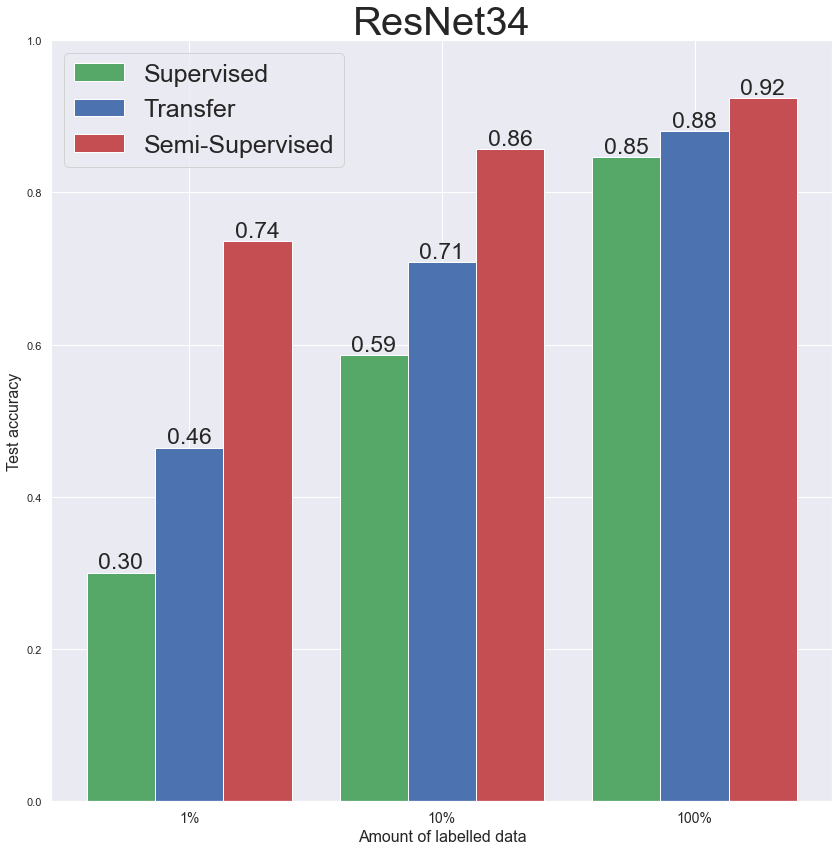

In [5]:
# Plot accuracy of finetuned models
sns.set()
with open("metrics_34.pkl", "rb") as f:
    metrics = pickle.load(f)

performance_metrics = {}
for model in metrics.keys():
    for frac in metrics[model].keys():
        avg = 0
        for fold in metrics[model][frac].keys():
            avg += metrics[model][frac][fold]['acc_test']
        performance_metrics[model+' '+frac] = avg/10
performance_metrics

plt.rcParams['figure.figsize']=(14,14)
N = 3
performance_vals = [value for value in performance_metrics.values()]
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

base = [i for i in performance_vals[0:3]]
rects2 = ax.bar(ind, base, width, color='g')
transfer = [i for i in performance_vals[3:6]]
rects3 = ax.bar(ind+width, transfer, width, color='b')
pre = [i for i in performance_vals[6:]]
rects1 = ax.bar(ind+width*2, pre, width, color='r')

ax.set_ylabel('Test accuracy', fontsize=16)
ax.set_xlabel("Amount of labelled data", fontsize=16)
ax.set_xticks(ind+width)
ax.set_xticklabels( ('1%', '10%', '100%'), fontsize=14)
ax.set_ylim([0,1])
ax.legend((rects2[0], rects3[0], rects1[0]), ('Supervised', 'Transfer','Semi-Supervised'), loc='upper left', fontsize=25)
ax.set_title("ResNet34",fontsize=40)

for rect in rects1 + rects2 + rects3:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f"{height:.2f}", ha='center', va='bottom', fontsize=23)



Files already downloaded and verified


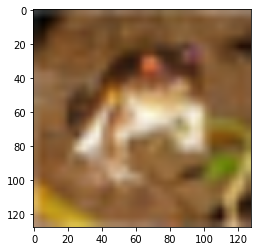

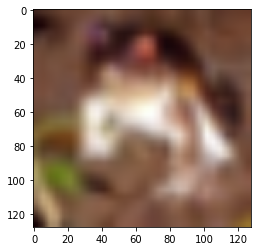

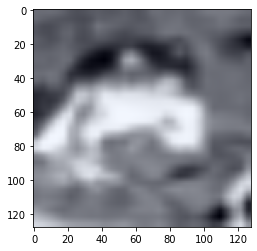

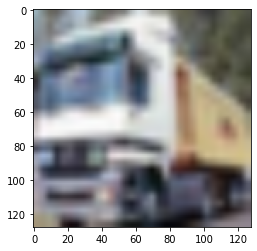

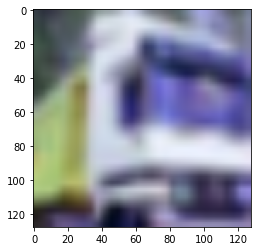

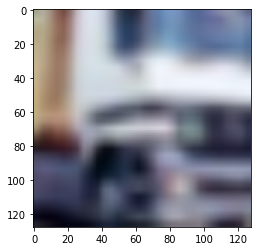

In [3]:
import matplotlib.pyplot as plt
import cv2
import torchvision
from torchvision import transforms
seed_everything(7)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])
ds_train = torchvision.datasets.CIFAR10('data', download=True, transform = transforms.ToTensor())


sample_dl = torch.utils.data.DataLoader(ds_train, batch_size=2)
X = next(iter(sample_dl))[0][0]
resize = torchvision.transforms.Resize((128,128))
X = resize(X)
X1 = train_transform(X)
X2 = train_transform(X)
image_data1 = torch.permute(X, (1,2,0)).numpy()
plt.imshow(image_data1)
plt.imsave("Image1.png",image_data1)
plt.show()
X1 = resize(X1)
X1 = torch.permute(X1, (1,2,0)).numpy()
X1_mask = np.zeros((128,128))
transform_data1 = cv2.normalize(X1, X1_mask, 0, 1, cv2.NORM_MINMAX)
transform_data1 = np.clip(transform_data1, 0, 1)
# transform_data1 = resize(transform_data1, (128,128))
# print(transform_data1.min(), transform_data1.max())
plt.imshow(transform_data1)
plt.imsave("Image1T1.png",transform_data1)
plt.show()
X2 = resize(X2)
X2 = torch.permute(X2, (1,2,0)).numpy()
X2_mask = np.zeros((128,128))
transform_data2 = cv2.normalize(X2, X2_mask, 0, 1, cv2.NORM_MINMAX)
transform_data2 = np.clip(transform_data2, 0, 1)
# transform_data2 = resize(transform_data2, (128,128))
plt.imshow(transform_data2)
plt.imsave("Image1T2.png", transform_data2)
plt.show()


Y = next(iter(sample_dl))[0][1]
Y = resize(Y)
Y1 = train_transform(Y)
Y2 = train_transform(Y)
image_data2 = torch.permute(Y, (1,2,0)).numpy()
plt.imshow(image_data2)
plt.imsave("Image2.png", image_data2)
plt.show()

Y1 = resize(Y1)
Y1 = torch.permute(Y1, (1,2,0)).numpy()
Y1_mask = np.zeros((128,128))
transform_data1 = cv2.normalize(Y1, Y1_mask, 0, 1, cv2.NORM_MINMAX)
transform_data1 = np.clip(transform_data1, 0, 1)
plt.imshow(transform_data1)
plt.imsave("Image2T1.png",transform_data1)
plt.show()

Y2 = resize(Y2)
Y2 = torch.permute(Y2, (1,2,0)).numpy()
Y2_mask = np.zeros((128,128))
transform_data2 = cv2.normalize(Y2, Y2_mask, 0, 1, cv2.NORM_MINMAX)
transform_data2 = np.clip(transform_data2, 0, 1)
plt.imshow(transform_data2)
plt.imsave("Image2T2.png", transform_data2)
plt.show()